# Monte Carlo Portfolio Risk Analysis
## VaR / CVaR Estimation, Backtesting, Basel Traffic Light, and GARCH(1,1)-t

**Goal:** Estimate 1-day 99% Value-at-Risk (VaR) and Conditional VaR (CVaR) for a multi-asset portfolio using:
- Parametric (delta-normal) VaR
- Monte Carlo (multivariate normal)
- Historical bootstrap Monte Carlo
- GARCH(1,1)-t VaR (time-varying volatility)

Then backtest each VaR model using a rolling window and evaluate exceedances (exceptions) using:
- Exception rate
- Kupiec POF test
- Basel traffic light (last 250 days)

In [1]:
import sys
import os

# Get project root (one level up from notebooks/)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)
REPORTS_DIR = os.path.join(PROJECT_ROOT, "reports")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

print("Project root added to path:", PROJECT_ROOT)
print("Data directory:", DATA_DIR)
print("Reports directory:", REPORTS_DIR)

Project root added to path: C:\Users\dipes\Desktop\Projects\montecarlo-var
Data directory: C:\Users\dipes\Desktop\Projects\montecarlo-var\data
Reports directory: C:\Users\dipes\Desktop\Projects\montecarlo-var\reports


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.data import download_prices, compute_returns
from src.simulate import mc_multivariate_normal, mc_bootstrap
from src.risk import var_cvar_from_returns, parametric_var
from src.backtests import rolling_backtest
from src.evaluate import basel_traffic_light
from src.garch_var import garch_rolling_var

pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

## Portfolio definition

In [3]:
TICKERS = ["AAPL", "MSFT", "AMZN", "NVDA", "JPM", "TLT"]
WEIGHTS = np.array([0.18, 0.18, 0.18, 0.18, 0.18, 0.10])
WEIGHTS = WEIGHTS / WEIGHTS.sum()

START_DATE = "2018-01-01"
ALPHA = 0.99
WINDOW = 500

pd.DataFrame({"Ticker": TICKERS, "Weight": WEIGHTS})

,Ticker,Weight
0,AAPL,0.180000
1,MSFT,0.180000
2,AMZN,0.180000
3,NVDA,0.180000
4,JPM,0.180000
5,TLT,0.100000


## Download prices

In [4]:
prices = download_prices(TICKERS, start=START_DATE)
file_path = os.path.join(DATA_DIR, "prices.csv")
prices.to_csv(file_path)
prices.tail()

Ticker,AAPL,AMZN,JPM,MSFT,NVDA,TLT
Date,,,,,,
2026-02-20,264.579987,210.110001,310.790009,397.230011,189.820007,89.410004
2026-02-23,266.179993,205.270004,297.670013,384.470001,191.550003,89.739998
2026-02-24,272.140015,208.559998,297.299988,389.000000,192.850006,89.900002
2026-02-25,274.230011,210.639999,303.299988,400.600006,195.559998,89.910004
2026-02-26,272.950012,207.919998,306.130005,401.720001,184.889999,90.269997


## Plot prices

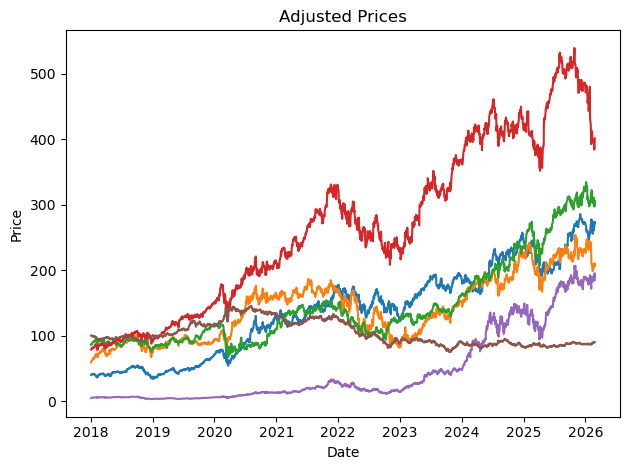

In [5]:
plt.figure()
plt.plot(prices.index, prices.values)
plt.title("Adjusted Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

## Compute returns

In [6]:
rets = compute_returns(prices, method="log")
rets.describe().T[["mean", "std", "min", "max"]]

,mean,std,min,max
Ticker,,,,
AAPL,0.000934,0.019333,-0.137708,0.142617
AMZN,0.000611,0.021642,-0.151398,0.126949
JPM,0.000618,0.018263,-0.162106,0.165620
MSFT,0.000795,0.018007,-0.159454,0.132929
NVDA,0.001770,0.032128,-0.207711,0.218088
TLT,-0.000051,0.009853,-0.069010,0.072503


## Portfolio return series

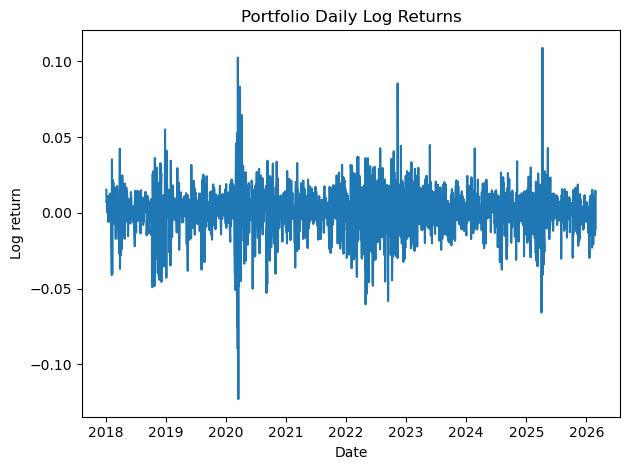

In [7]:
port_rets = rets.values @ WEIGHTS
port_rets = pd.Series(port_rets, index=rets.index, name="PortfolioLogReturn")

plt.figure()
plt.plot(port_rets.index, port_rets.values)
plt.title("Portfolio Daily Log Returns")
plt.xlabel("Date")
plt.ylabel("Log return")
plt.tight_layout()
plt.show()

## Simulate portfolio returns

In [8]:
N_SIMS = 100_000

sims_norm = mc_multivariate_normal(rets, WEIGHTS, n_sims=N_SIMS, seed=1)
sims_boot = mc_bootstrap(rets, WEIGHTS, n_sims=N_SIMS, seed=1)
pr_norm = sims_norm["port_returns"]
pr_boot = sims_boot["port_returns"]

pr_norm.mean(), pr_norm.std(ddof=1), pr_boot.mean(), pr_boot.std(ddof=1)

(np.float64(0.0008193051420907966),
 np.float64(0.015459209744837395),
 np.float64(0.0008807681821593241),
 np.float64(0.015492133224151904))

## Compute VaR / CVaR + parametric VaR 

In [9]:
var_p = parametric_var(rets, WEIGHTS, alpha=ALPHA)

stats_n = var_cvar_from_returns(pr_norm, alpha=ALPHA)
stats_b = var_cvar_from_returns(pr_boot, alpha=ALPHA)

var_n, cvar_n = stats_n["VaR"], stats_n["CVaR"]
var_b, cvar_b = stats_b["VaR"], stats_b["CVaR"]
summary = pd.DataFrame({
    "Method": ["Parametric (delta-normal)", "MC Normal", "Bootstrap"],
    "VaR_99": [var_p, var_n, var_b],
    "CVaR_99": [np.nan, cvar_n, cvar_b],
}).set_index("Method")

summary

,VaR_99,CVaR_99
Method,,
Parametric (delta-normal),0.035344,NaN
MC Normal,0.035333,0.040628
Bootstrap,0.044598,0.056221


## Plot loss distribution with VaR/CVaR

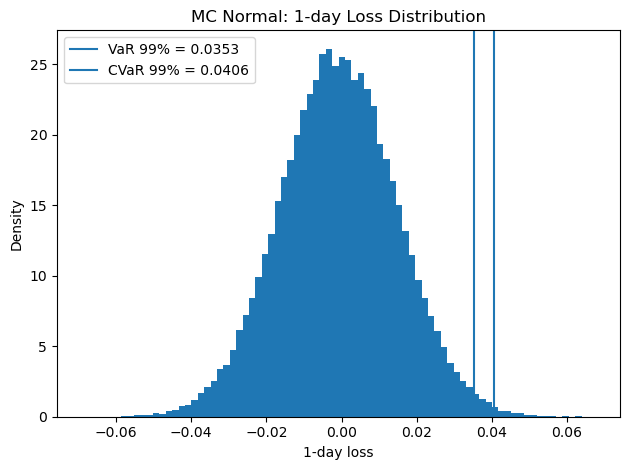

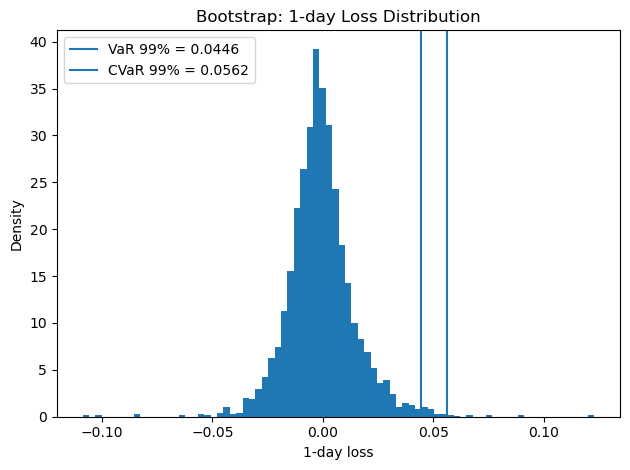

In [10]:
def plot_loss_dist(sim_returns, var_val, cvar_val=None, title="Loss Distribution"):
    losses = -np.asarray(sim_returns)
    plt.figure()
    plt.hist(losses, bins=80, density=True)
    plt.axvline(var_val, label=f"VaR 99% = {var_val:.4f}")
    if cvar_val is not None:
        plt.axvline(cvar_val, label=f"CVaR 99% = {cvar_val:.4f}")
    plt.title(title)
    plt.xlabel("1-day loss")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_loss_dist(pr_norm, var_n, cvar_n, "MC Normal: 1-day Loss Distribution")
plot_loss_dist(pr_boot, var_b, cvar_b, "Bootstrap: 1-day Loss Distribution")

## Backtest (Parametric / MC / Bootstrap)

In [11]:
res_p, stats_p = rolling_backtest(rets, WEIGHTS, method="parametric", window=WINDOW, alpha=ALPHA)
res_n, stats_n = rolling_backtest(rets, WEIGHTS, method="mc_normal", window=WINDOW, n_sims=30_000, alpha=ALPHA)
res_b, stats_b = rolling_backtest(rets, WEIGHTS, method="mc_bootstrap", window=WINDOW, n_sims=30_000, alpha=ALPHA)

stats_p, stats_n, stats_b

({'method': 'parametric',
  'alpha': 0.99,
  'window': 500,
  'n_obs': 1548,
  'n_exceptions': 37,
  'exception_rate': 0.023901808785529714,
  'kupiec_LR': 21.744922588906093,
  'kupiec_p_value': 3.114129562220569e-06},
 {'method': 'mc_normal',
  'alpha': 0.99,
  'window': 500,
  'n_obs': 1548,
  'n_exceptions': 35,
  'exception_rate': 0.02260981912144703,
  'kupiec_LR': 18.315635892300236,
  'kupiec_p_value': 1.871646746154365e-05},
 {'method': 'mc_bootstrap',
  'alpha': 0.99,
  'window': 500,
  'n_obs': 1548,
  'n_exceptions': 24,
  'exception_rate': 0.015503875968992248,
  'kupiec_LR': 4.055692897827637,
  'kupiec_p_value': 0.04402264893727714})

## Backtest summary table

In [12]:
bt_summary = pd.DataFrame([stats_p, stats_n, stats_b])
bt_summary = bt_summary[["method", "n_obs", "n_exceptions", "exception_rate", "kupiec_LR", "kupiec_p_value"]]
bt_summary

,method,n_obs,n_exceptions,exception_rate,kupiec_LR,kupiec_p_value
0,parametric,1548,37,0.023902,21.744923,0.000003
1,mc_normal,1548,35,0.022610,18.315636,0.000019
2,mc_bootstrap,1548,24,0.015504,4.055693,0.044023


## Plot backtest

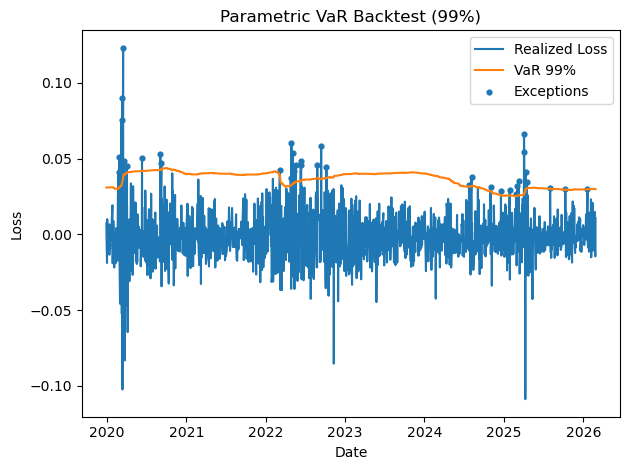

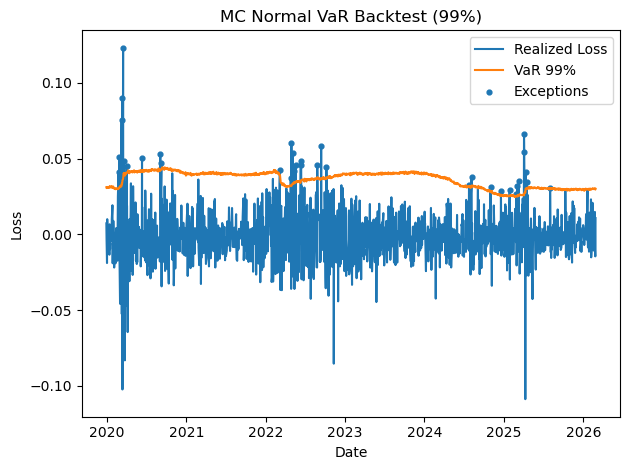

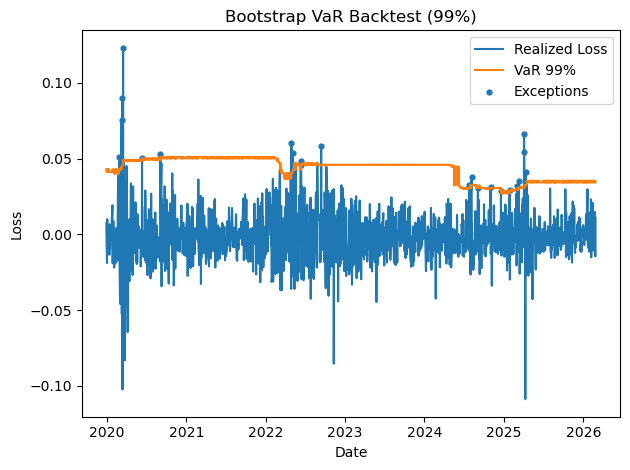

In [13]:
def plot_backtest(df, title):
    plt.figure()
    plt.plot(df.index, df["RealizedLoss"], label="Realized Loss")
    plt.plot(df.index, df["VaR"], label="VaR 99%")
    exc = df[df["Exception"] == 1]
    if len(exc) > 0:
        plt.scatter(exc.index, exc["RealizedLoss"], s=12, label="Exceptions")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_backtest(res_p, "Parametric VaR Backtest (99%)")
plot_backtest(res_n, "MC Normal VaR Backtest (99%)")
plot_backtest(res_b, "Bootstrap VaR Backtest (99%)")

## Basel classification

In [14]:
def basel_last250(df):
    x250 = int(df["Exception"].tail(250).sum())
    zone, expl = basel_traffic_light(x250)
    return x250, zone, expl

basel_table = pd.DataFrame([
    ("parametric",) + basel_last250(res_p),
    ("mc_normal",) + basel_last250(res_n),
    ("mc_bootstrap",) + basel_last250(res_b),
], columns=["method", "exceptions_250", "zone", "notes"]).set_index("method")

basel_table

,exceptions_250,zone,notes
method,,,
parametric,9,YELLOW,5-9 exceptions (increased scrutiny / multiplier)
mc_normal,7,YELLOW,5-9 exceptions (increased scrutiny / multiplier)
mc_bootstrap,5,YELLOW,5-9 exceptions (increased scrutiny / multiplier)


## GARCH(1,1)-t VaR
### Run GARCH backtest

In [15]:
res_g = garch_rolling_var(rets, WEIGHTS, window=WINDOW, alpha=ALPHA, dist="t", refit_every=20)
garch_stats = {
    "method": "garch_t",
    "n_obs": len(res_g),
    "n_exceptions": int(res_g["Exception"].sum()),
    "exception_rate": float(res_g["Exception"].mean()),
}
garch_stats

{'method': 'garch_t',
 'n_obs': 1548,
 'n_exceptions': 24,
 'exception_rate': 0.015503875968992248}

## Plot GARCH backtest

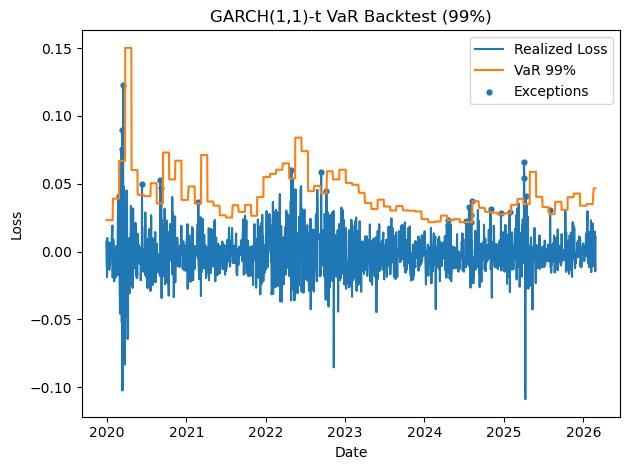

In [16]:
plot_backtest(res_g, "GARCH(1,1)-t VaR Backtest (99%)")

## Basel traffic light including GARCH

In [17]:
basel_table_garch = pd.DataFrame([
    ("parametric",) + basel_last250(res_p),
    ("mc_normal",) + basel_last250(res_n),
    ("mc_bootstrap",) + basel_last250(res_b),
    ("garch_t",) + basel_last250(res_g),
], columns=["method", "exceptions_250", "zone", "notes"]).set_index("method")

basel_table_garch

,exceptions_250,zone,notes
method,,,
parametric,9,YELLOW,5-9 exceptions (increased scrutiny / multiplier)
mc_normal,7,YELLOW,5-9 exceptions (increased scrutiny / multiplier)
mc_bootstrap,5,YELLOW,5-9 exceptions (increased scrutiny / multiplier)
garch_t,4,GREEN,0-4 exceptions (acceptable)


## Save key tables to reports/

In [18]:
summary.to_csv(os.path.join(REPORTS_DIR, "var_cvar_summary.csv"))
bt_summary.to_csv(os.path.join(REPORTS_DIR, "backtest_summary.csv"), index=False)
basel_table_garch.to_csv(os.path.join(REPORTS_DIR, "basel_traffic_light.csv"))

## Discussion

- **Parametric and MC Normal VaR** assume normality and tend to underestimate tail risk in markets with fat tails and volatility clustering.
- **Bootstrap VaR** improves tail estimation by using empirical returns but does not model time-varying volatility.
- **GARCH(1,1)-t VaR** captures volatility clustering and adapts VaR during stress, improving regulatory-style performance (Basel traffic light).

## Limitations
- Assumes weights are constant and ignores transaction costs/rebalancing.
- Uses a single rolling window size (sensitivity analysis could be added).
- Portfolio-level GARCH ignores cross-asset conditional correlation dynamics.
